In [5]:
import pandas as pd
import nlpaug.augmenter.word as naw

In [6]:
folder = 'data_yang_dipake/'

In [7]:
df = pd.read_csv(f'{folder}dataML.csv')

In [8]:
df.head()

Unnamed: 0                                          full_text  Label
0           0  @Iam_Nobody_1145 Sama aja dong kek kasus kudat...    2.0
1           1  @Bambangmulyonoo @PDI_Perjuangan Salah satu ya...    2.0
2           2  @Miduk17 @agussusilo7562 @ganjarpranowo @mohma...    2.0
3           3  @Paltiwest Pdi p jgn mw menampung mental2 pngk...    2.0
4           4  @Minietweets_ @adri_7i @adi_sareang @alextham8...    0.0

In [9]:
df = df.drop(columns='Unnamed: 0')

In [10]:
df['full_text'] = df['full_text'].astype(str)

In [11]:
df = df.dropna()

In [12]:
df['Label'] = df['Label'].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3430 entries, 0 to 3432
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  3430 non-null   object
 1   Label      3430 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 67.0+ KB


In [14]:
import re

# Translate emoticon
emoticon_data_path = 'external/emoticon.txt'
emoticon_df = pd.read_csv(emoticon_data_path, sep='\t', header=None)
emoticon_dict = dict(zip(emoticon_df[0], emoticon_df[1]))

def translate_emoticon(t):
    for w, v in emoticon_dict.items():
        pattern = re.compile(re.escape(w))
        match = re.search(pattern,t)
        if match:
            t = re.sub(pattern,v,t)
    return t

In [15]:
def remove_newline(text):
    return re.sub('\n', ' ',text)

In [16]:
def remove_url(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)

In [17]:
def remove_excessive_whitespace(text):
    return re.sub('  +', ' ', text)

In [18]:
from nltk.tokenize import WordPunctTokenizer

def tokenize_text(text, punct=False):
    text = WordPunctTokenizer().tokenize(text)
    text = [word for word in text if punct or word.isalnum()]
    text = ' '.join(text)
    text = text.strip()
    return text

In [19]:
slang_words = pd.read_csv('external/slangword.csv')
slang_dict = dict(zip(slang_words['original'],slang_words['translated']))

def transform_slang_words(text):
    word_list = text.split()
    word_list_len = len(word_list)
    transformed_word_list = []
    i = 0
    while i < word_list_len:
        if (i + 1) < word_list_len:
            two_words = ' '.join(word_list[i:i+2])
            if two_words in slang_dict:
                transformed_word_list.append(slang_dict[two_words])
                i += 2
                continue
        transformed_word_list.append(slang_dict.get(word_list[i], word_list[i]))
        i += 1
    return ' '.join(transformed_word_list)

In [20]:
def remove_non_alphabet(text):
    output = re.sub('[^a-zA-Z ]+', '', text)
    return output

In [21]:
def remove_twitter_formatting(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'\brt\b', '', text)
    return text

In [22]:
import itertools

def remove_repeating_characters(text):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))

In [23]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    output = stemmer.stem(text)
    return output

In [24]:
def preprocess_text(text):
    transformed_text = text.lower()
    transformed_text = remove_newline(text)
    transformed_text = remove_url(transformed_text)
    transformed_text = remove_twitter_formatting(transformed_text)
    transformed_text = translate_emoticon(transformed_text)
    transformed_text = transformed_text.lower()
    transformed_text = tokenize_text(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_repeating_characters(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_non_alphabet(transformed_text)
    transformed_text = remove_excessive_whitespace(transformed_text)
    transformed_text = transformed_text.lower().strip()
    transformed_text = stemming(transformed_text)
    return transformed_text

In [25]:
df['preprocess'] = df['full_text'].apply(preprocess_text)

In [26]:
label_map = {0: 'Positive', 1: 'Toxic', 2: 'Critique', 3: 'Others'}

In [27]:
df['Sentiment'] = df['Label'].replace(label_map)

In [28]:
df.head()

full_text  Label  \
0  @Iam_Nobody_1145 Sama aja dong kek kasus kudat...      2   
1  @Bambangmulyonoo @PDI_Perjuangan Salah satu ya...      2   
2  @Miduk17 @agussusilo7562 @ganjarpranowo @mohma...      2   
3  @Paltiwest Pdi p jgn mw menampung mental2 pngk...      2   
4  @Minietweets_ @adri_7i @adi_sareang @alextham8...      0   

                                          preprocess Sentiment  
0  sama saja dong seperti kasus kudatuli yang tid...  Critique  
1  salah satu yang kencang teriak periode buzer p...  Critique  
2         tapi pdi tidak berani atau jadi halang yah  Critique  
3  pdi p jangan mau tampung mental pngkhianat jk ...  Critique  
4  pdip deh pdi kan sudah biasa begini bahkan dul...  Positive

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from sklearn.pipeline import Pipeline

ngram_range = (1, 2)
max_features = 1000

# Create a CountVectorizer object with the specified n-gram range and maximum number of features
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

# Create a MultinomialNB object for classification
clf = tree.DecisionTreeClassifier()

# Create a Pipeline object to combine the vectorizer and classifier
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', clf)
])

In [30]:
X = df['preprocess']
y = df['Sentiment']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('clf', DecisionTreeClassifier())])

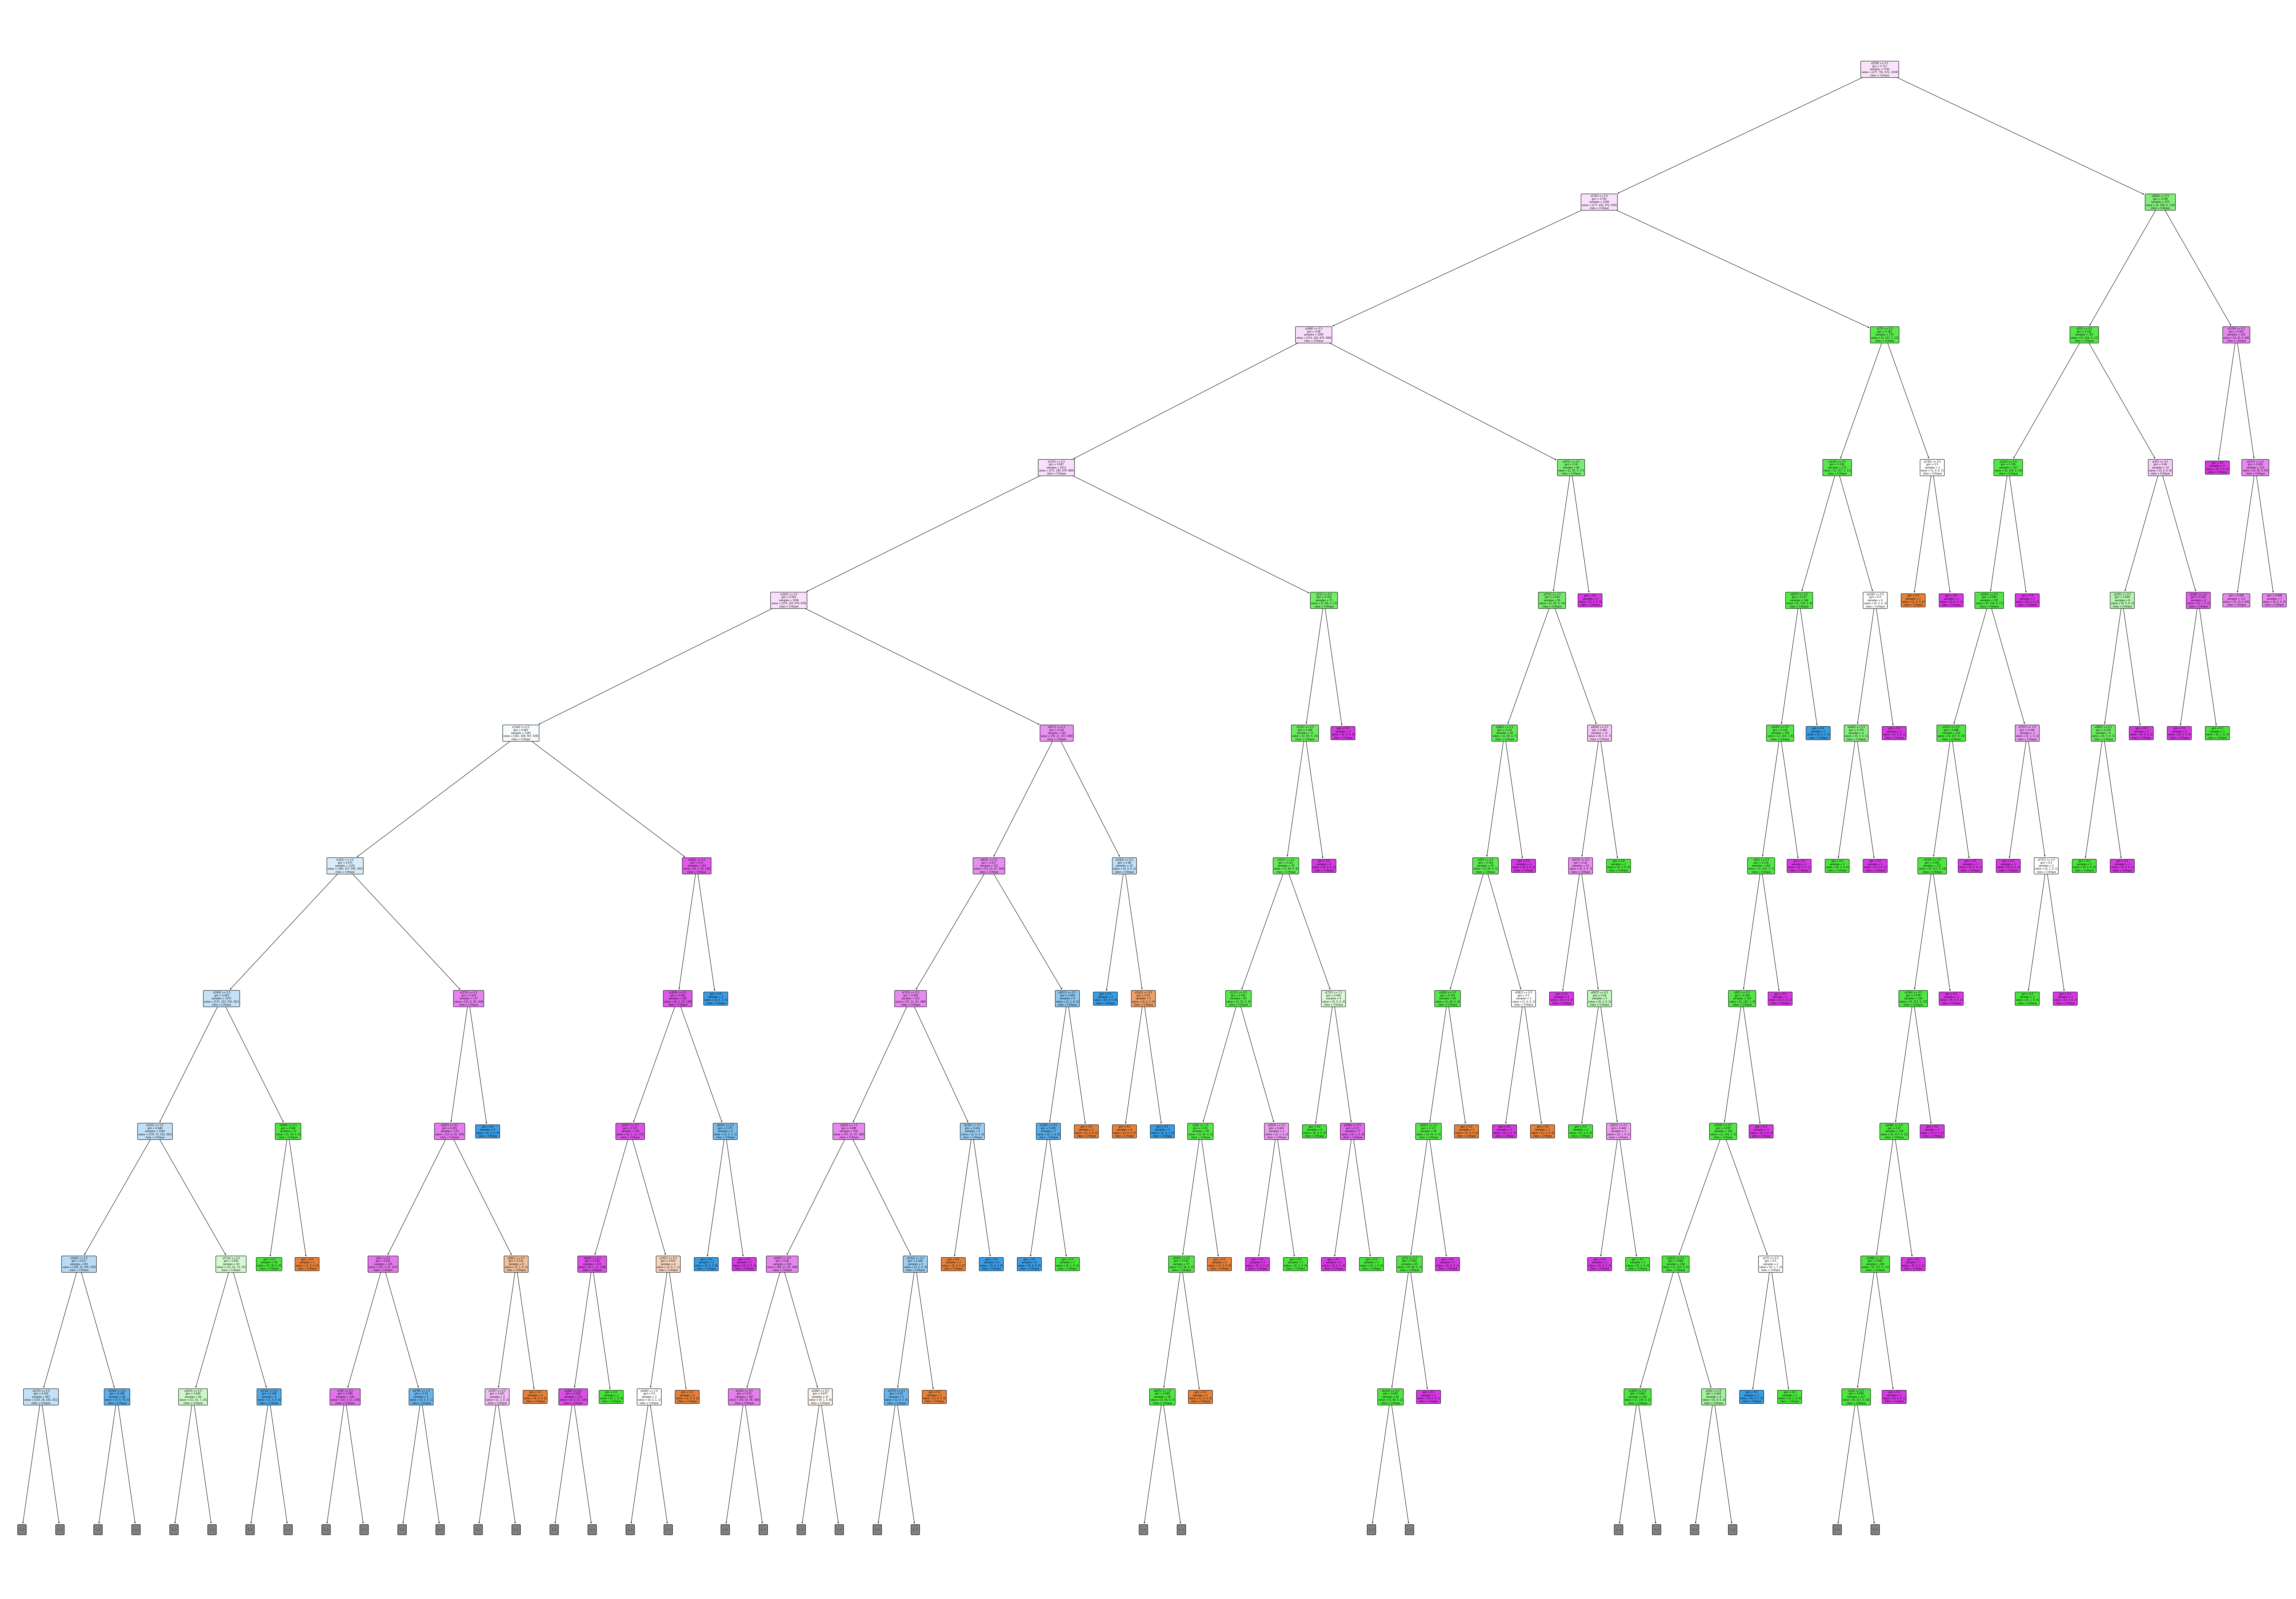

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100,70))
plot_tree(clf, class_names=df.Sentiment, filled=True, rounded=True, max_depth=10)
plt.show()

In [34]:
prediction = pipeline.predict(X_test)

In [35]:
from sklearn.metrics import f1_score
import numpy as np
score = np.round(f1_score(y_test, prediction, average='micro'),4)
print('F-1 score of model with n-gram range of {}: {}'.format(ngram_range, score))

F-1 score of model with n-gram range of (1, 2): 0.6283


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

    Critique       0.14      0.14      0.14        66
      Others       0.90      0.78      0.83       189
    Positive       0.51      0.55      0.53       162
       Toxic       0.65      0.69      0.67       269

    accuracy                           0.63       686
   macro avg       0.55      0.54      0.54       686
weighted avg       0.64      0.63      0.63       686



In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
cm

array([[  9,   1,  29,  27],
       [  6, 147,  10,  26],
       [ 26,   2,  89,  45],
       [ 23,  14,  46, 186]], dtype=int64)

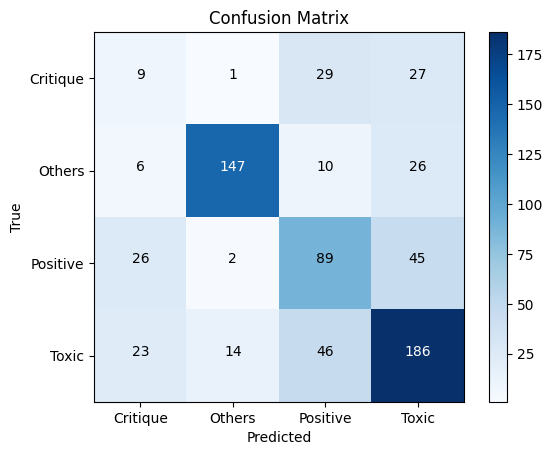

In [38]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.yticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

clf2 = tree.DecisionTreeClassifier()
max_features = 1000
vectorizer = TfidfVectorizer(max_features=max_features)

In [40]:
pipeline2 = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', clf2)
])

In [41]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000)),
                ('clf', DecisionTreeClassifier())])

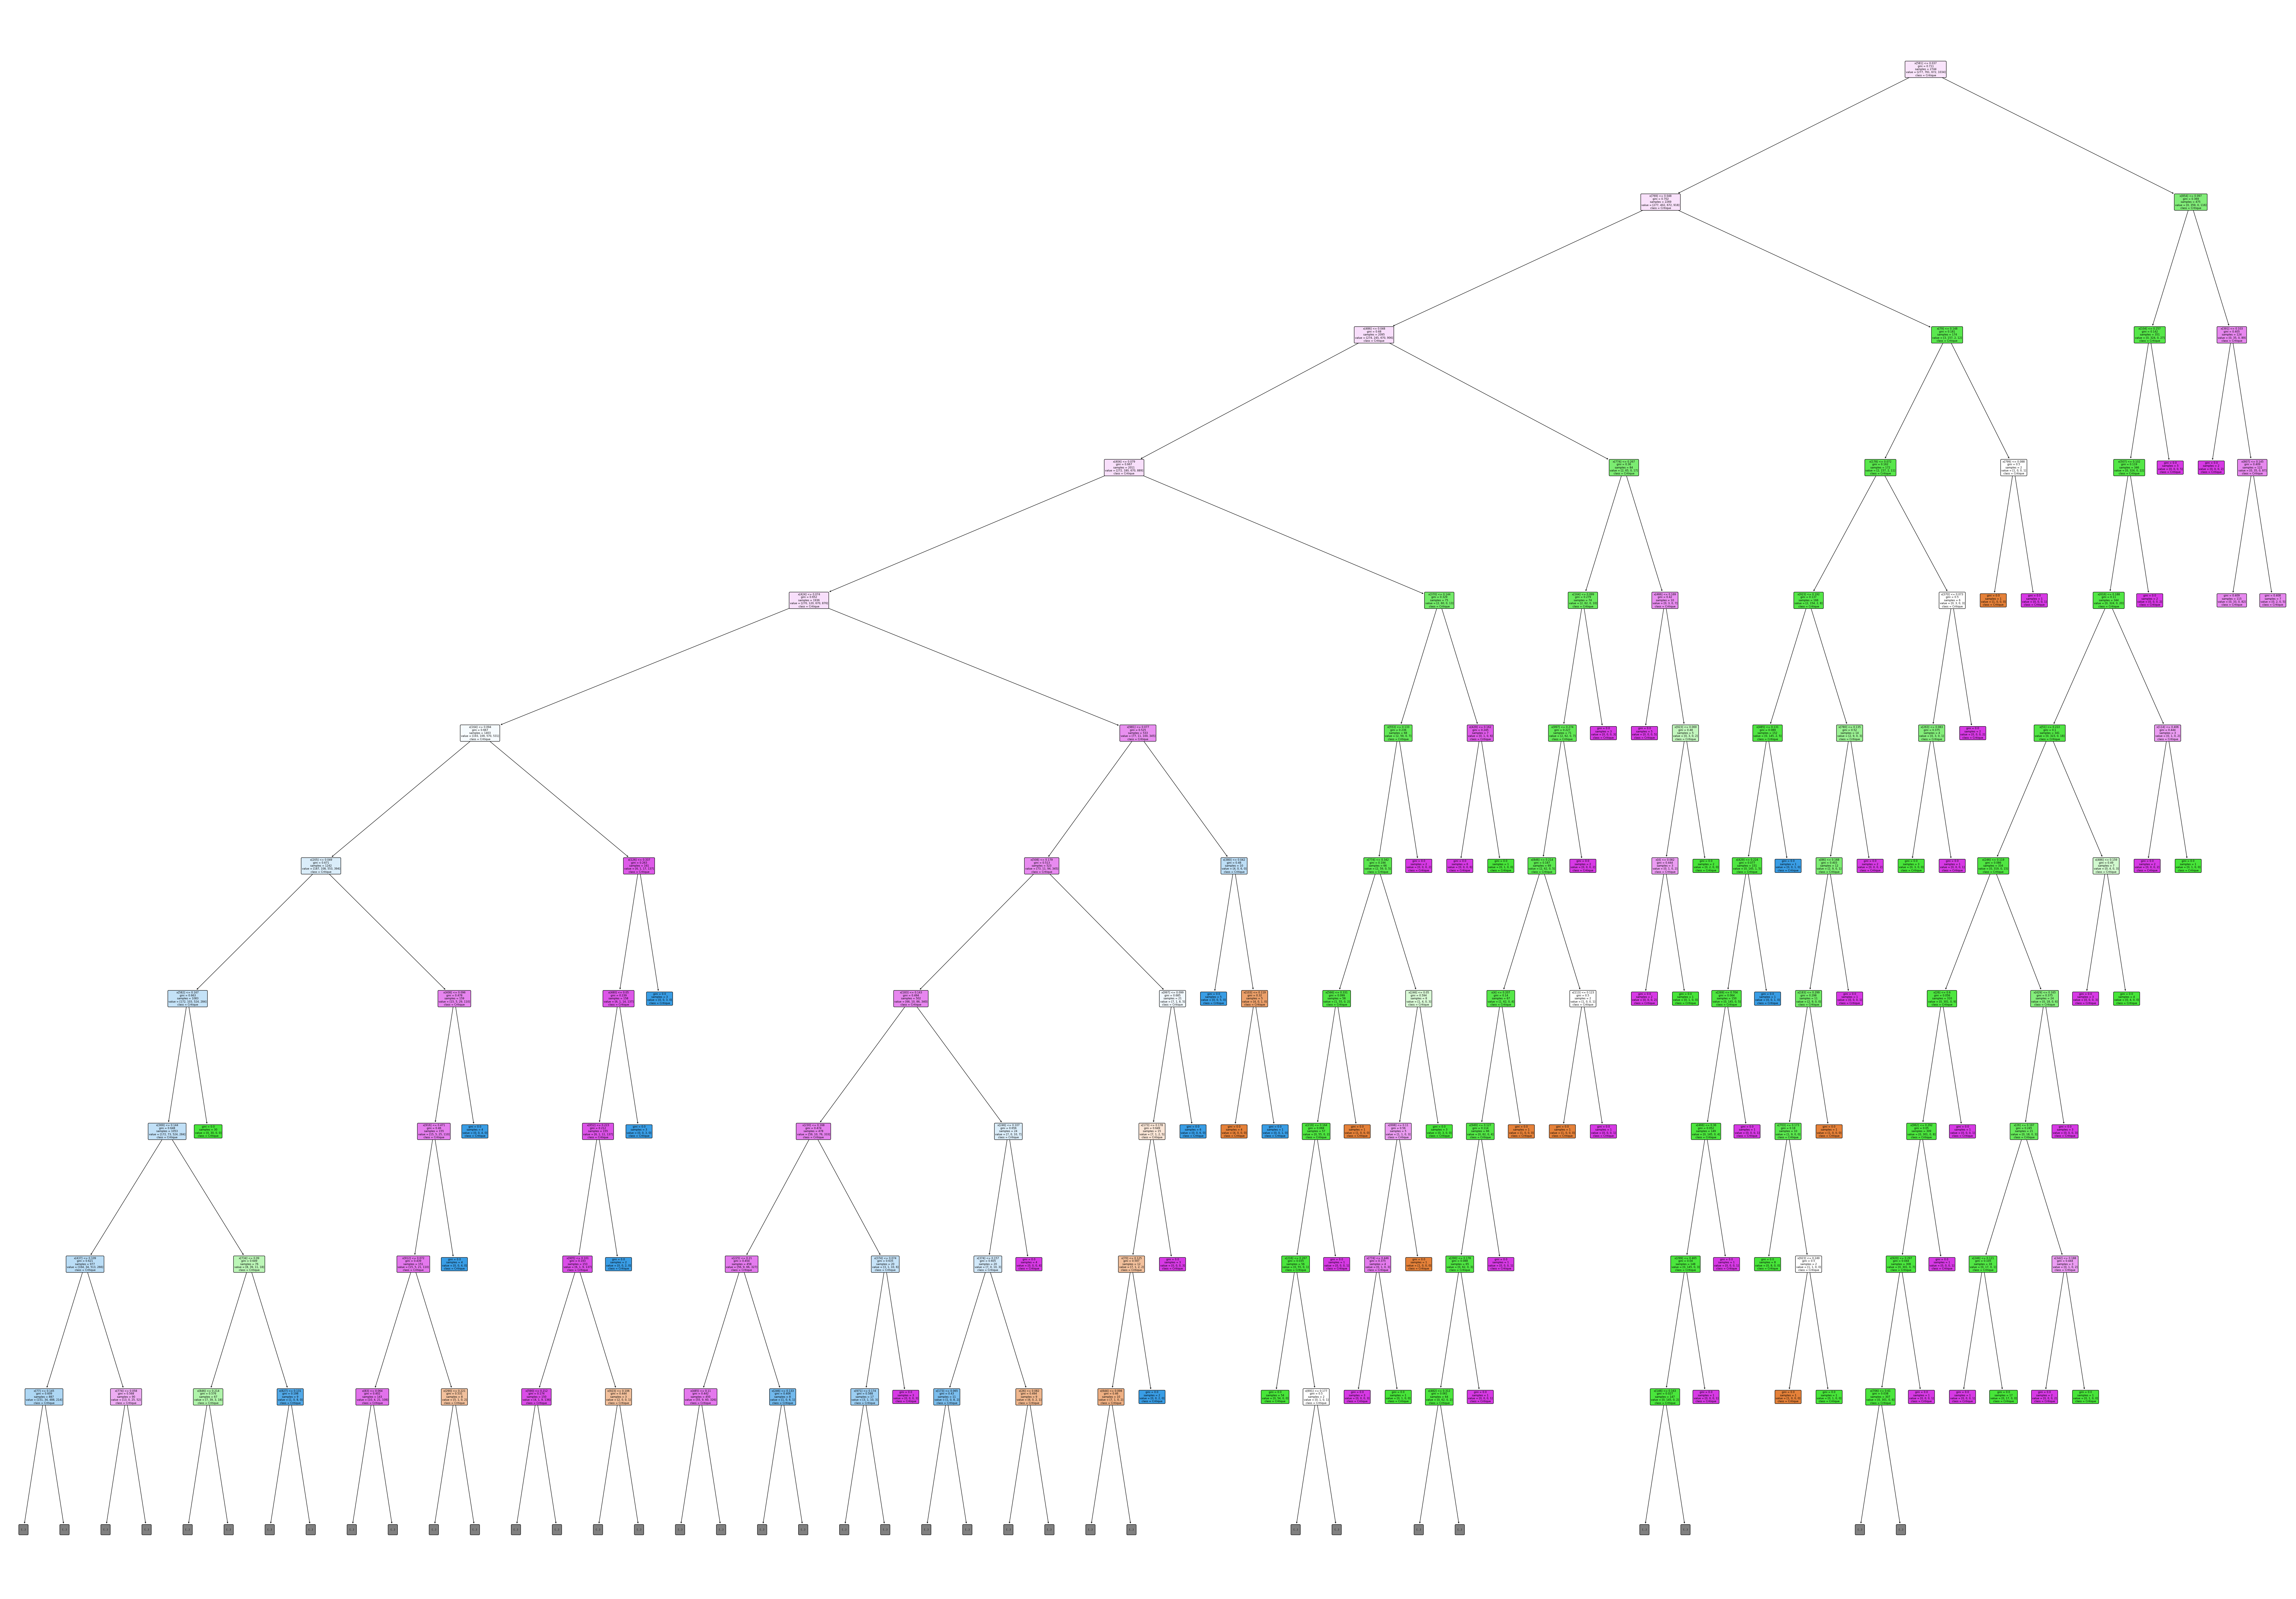

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100,70))
plot_tree(clf2, class_names=df.Sentiment, filled=True, rounded=True, max_depth=10)
plt.show()

In [43]:
predicts = pipeline.predict(X_test)


In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

    Critique       0.14      0.14      0.14        66
      Others       0.90      0.78      0.83       189
    Positive       0.51      0.55      0.53       162
       Toxic       0.65      0.69      0.67       269

    accuracy                           0.63       686
   macro avg       0.55      0.54      0.54       686
weighted avg       0.64      0.63      0.63       686



In [45]:
cm = confusion_matrix(y_test, predicts)
cm

array([[  9,   1,  29,  27],
       [  6, 147,  10,  26],
       [ 26,   2,  89,  45],
       [ 23,  14,  46, 186]], dtype=int64)

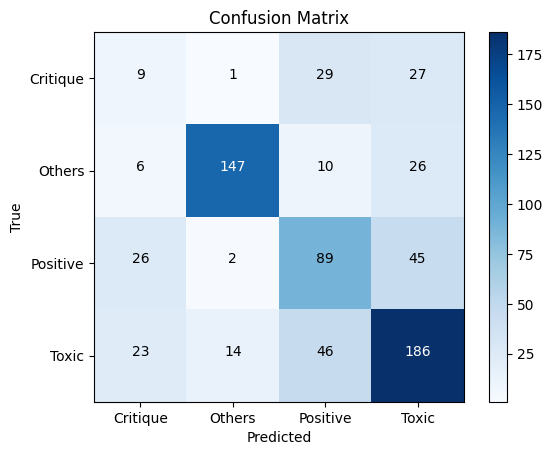

In [46]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.yticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [47]:
from gensim.models import Word2Vec

embedding_dim = 100

In [48]:
tokenized_training_data = [sentence.split() for sentence in X_train]

In [49]:
model = Word2Vec(sentences=tokenized_training_data, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [50]:
# Tokenize the test data
tokenized_test_data = [sentence.split() for sentence in X_test]

# Get the embeddings for the training and test data
training_data_embeddings = []
for sentence in tokenized_training_data:
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if embeddings:
        training_data_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        training_data_embeddings.append([0] * embedding_dim)

test_data_embeddings = []
for sentence in tokenized_test_data:
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if embeddings:
        test_data_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        test_data_embeddings.append([0] * embedding_dim)

In [51]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(training_data_embeddings, y_train)

predicted_labels = classifier.predict(test_data_embeddings)


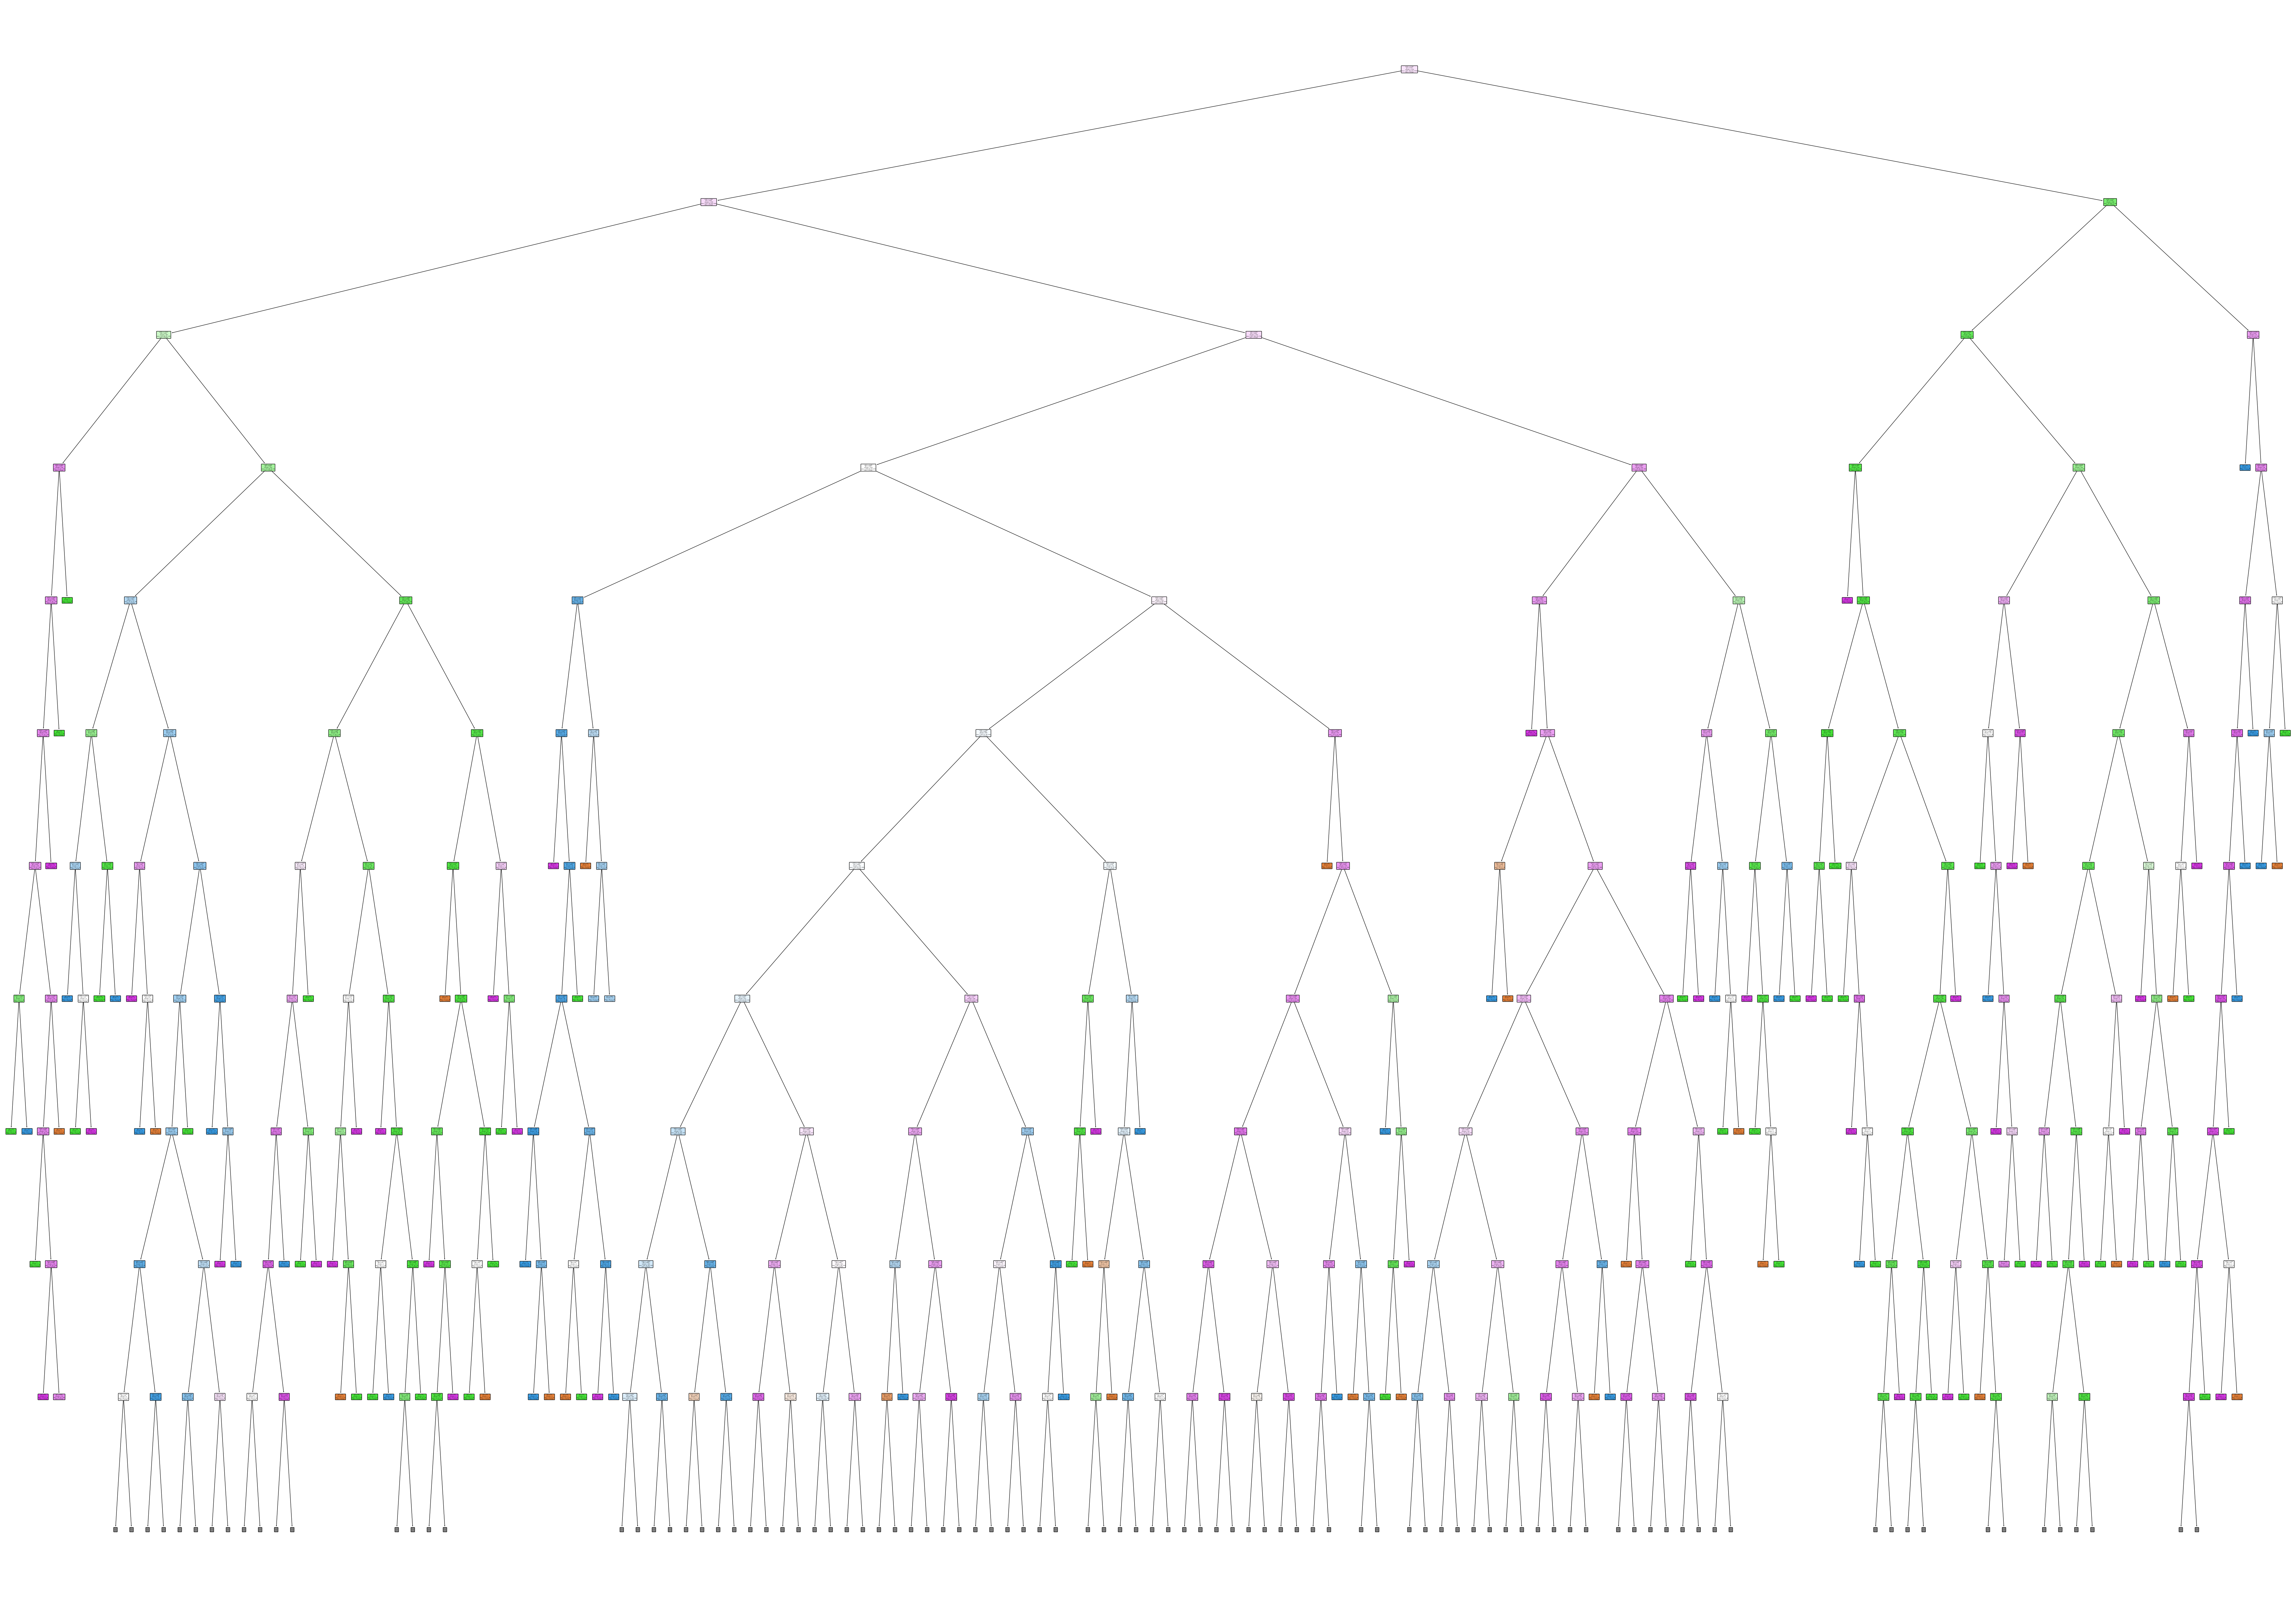

In [52]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100,70))
plot_tree(classifier, class_names=df.Sentiment, filled=True, rounded=True, max_depth=10)
plt.show()

In [53]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

    Critique       0.15      0.15      0.15        66
      Others       0.80      0.71      0.75       189
    Positive       0.44      0.43      0.43       162
       Toxic       0.58      0.63      0.60       269

    accuracy                           0.56       686
   macro avg       0.49      0.48      0.48       686
weighted avg       0.57      0.56      0.56       686



In [54]:
cm = confusion_matrix(y_test, predicted_labels)
cm

array([[ 10,   3,  26,  27],
       [  0, 134,  10,  45],
       [ 31,  10,  69,  52],
       [ 27,  20,  52, 170]], dtype=int64)

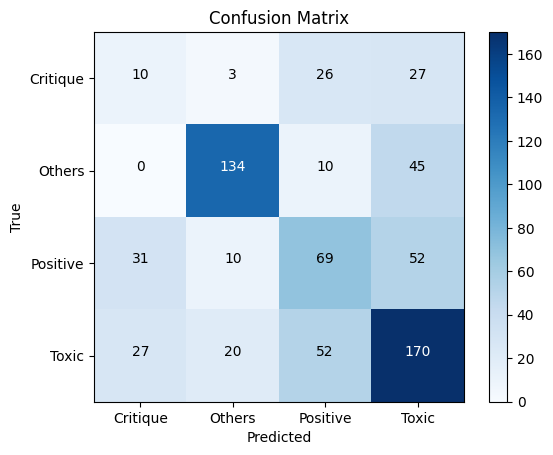

In [55]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.yticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [56]:
vectorizer2 = CountVectorizer()

In [57]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [58]:
clf3 = tree.DecisionTreeClassifier()
clf3.fit(X_train, y_train)

DecisionTreeClassifier()

In [59]:
y_pred = clf.predict(X_test)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Critique       0.00      0.00      0.00        66
      Others       0.00      0.00      0.00       189
    Positive       0.30      0.02      0.03       162
       Toxic       0.39      0.98      0.56       269

    accuracy                           0.39       686
   macro avg       0.17      0.25      0.15       686
weighted avg       0.23      0.39      0.23       686



In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[  0,   1,   0,  65],
       [  2,   0,   3, 184],
       [  1,   1,   3, 157],
       [  0,   1,   4, 264]], dtype=int64)

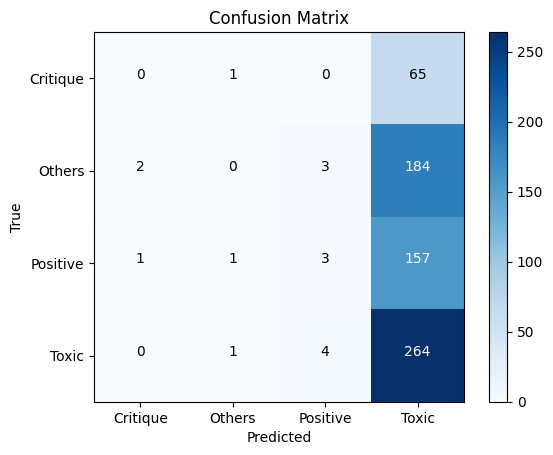

In [62]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.yticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")